Task-1 : Import libraries

In [114]:
import os
import csv
import time
import progressbar
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import sys, time, os, warnings
import numpy as np
import pandas as pd
import pickle as pkl
from collections import Counter
from keras.preprocessing.image import load_img
from nltk.tokenize import word_tokenize

warnings.filterwarnings("ignore")


In [84]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
Images_directory_extracted = '/content/drive/MyDrive/DL_Assignment_2/Image_captioning_Dataset/Flicker8k_Dataset/'
captions_pickle_path = '/content/drive/MyDrive/DL_Assignment_2/set_3.pkl'
parent_directory = '/content/drive/MyDrive/DL_Assignment_2'



In [87]:
with open(captions_pickle_path, "rb") as f:
  captions = pkl.load(f)


In [88]:
datatxt = []
for line in captions:
  col = line.split('\t')
  #print(col)
  if len(col) == 1:
    continue
  w = col[0].split("#")
  datatxt.append(w + [col[1].lower()])
captions_dict = pd.DataFrame(datatxt,columns=["filename","index","caption"])
unique_image_files = np.unique(captions_dict.filename.values)
print("The number of unique file names : {}".format(len(unique_image_files)))
print("The distribution of the number of captions for each image:")
Counter(Counter(captions_dict.filename.values).values())

The number of unique file names : 8017
The distribution of the number of captions for each image:


Counter({1: 522, 2: 1700, 3: 2854, 4: 2189, 5: 752})

In [89]:
def df_word(captions_dict):
  vocabulary = []
  for i in range(len(captions_dict)):
    temp=captions_dict.iloc[i,2]
    vocabulary.extend(temp.split())
    
  print('Vocabulary Size: %d' % len(set(vocabulary)))
  ct = Counter(vocabulary)
  dfword =pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
  dfword= dfword.sort_values("count",ascending=False)
  dfword =dfword.reset_index()[["word","count"]]
  return(dfword)

dfword = df_word(captions_dict)
dfword.head(3)
  

Vocabulary Size: 5521


word  count
0    a  42864
1    .  22608
2   in  11742

Data Processing(1  mark) 
 

1.Read the pickle file (https://drive.google.com/file/d/1QG2_tAFLroc4ATSOLRiEAwYTYTsL_xVc/view?usp=sharing) and convert the data into the correct format which could be used for ML model. 
 Pickle file contains the image id and the text associated with the image.

Eg: '319847657_2c40e14113.jpg#0\tA girl in a purple shirt hold a pillow .

Each image can have multiple captions.

319847657_2c40e14113.jpg -> image name

### #0 -> Caption ID

\t  -> separator between Image name and Image Caption

A girl in a purple shirt hold a pillow . -> Image Caption

Corresponding image wrt image name can be found in the image dataset folder.

 

Image dataset Folder : https://drive.google.com/file/d/1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1/view?usp=sharing

 

1.Plot at least two samples and their captions (use matplotlib/seaborn/any other library). 
2.Bring the train and test data in the required format. 

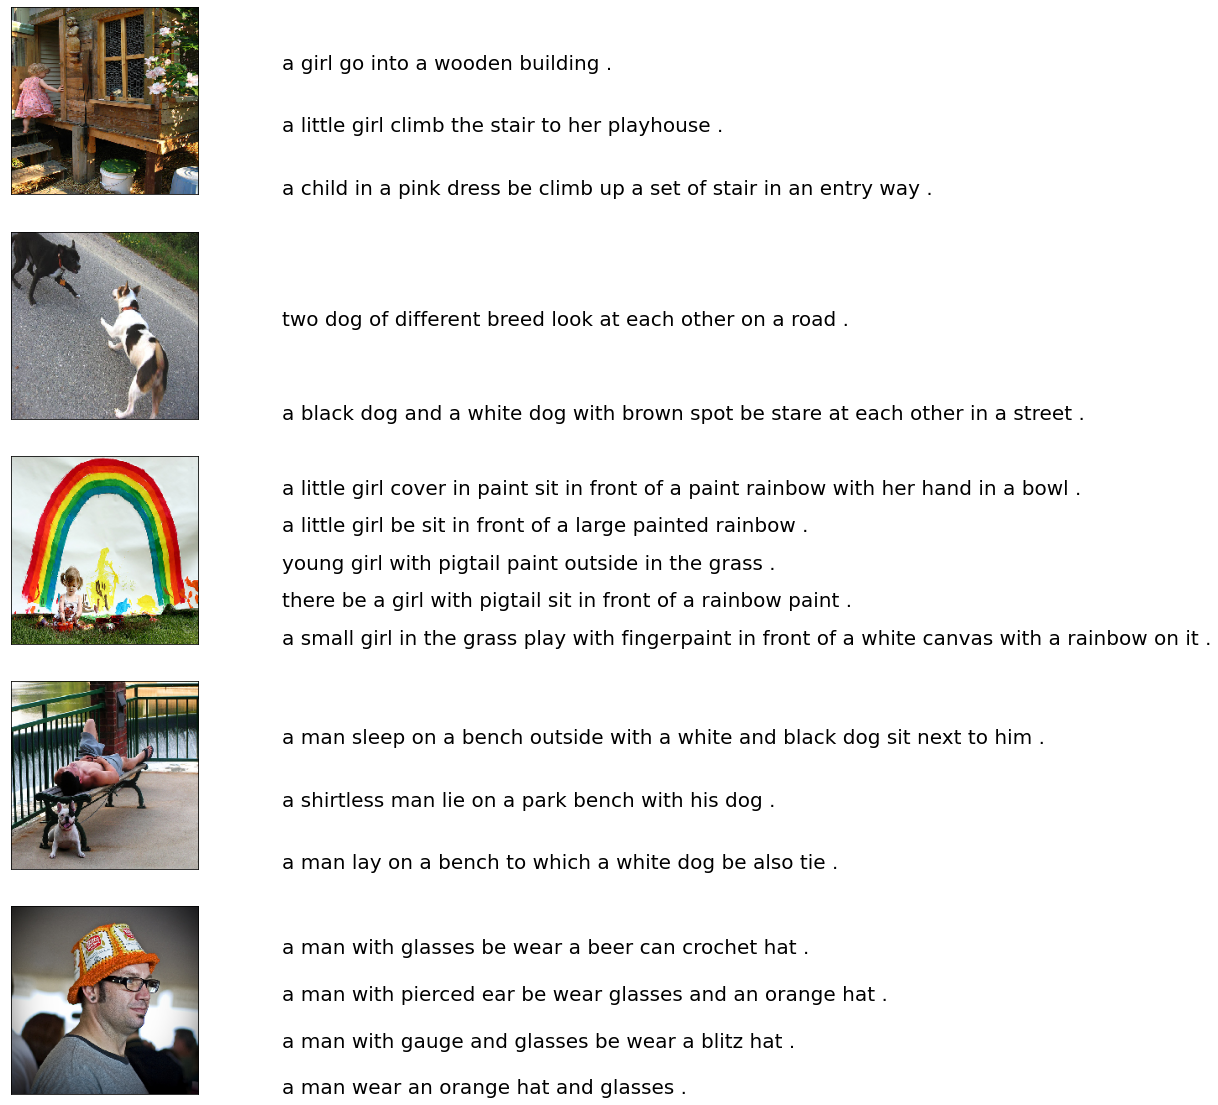

In [90]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix =224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10, 20))
for img in unique_image_files[:npic]:
  filename = Images_directory_extracted + img
  captions = list(captions_dict['caption'].loc[captions_dict["filename"]==img])
  image_load= load_img(filename, target_size=target_size)

  ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
  ax.imshow(image_load)
  count +=1

  ax = fig.add_subplot(npic,2,count)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(captions))
  for i, caption in enumerate(captions):
    ax.text(0,i,caption,fontsize=20)
  count+=1
plt.show()


In [91]:
import string

def remove_punctuation(text_original):
  text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
  return (text_no_punctuation)

def remove_single_character(text):
  text_len_more_than1 = ""
  for word in text.split():
    if len(word) > 1: 
      text_len_more_than1 += " " + word
  return(text_len_more_than1)

def remove_numeric(text,printTF=False):
  text_no_numeric = ""
  for word in text.split():
    isalpha = word.isalpha()
    if printTF: 
      print(" {:10} : {:}".format(word,isalpha))
    if isalpha: 
      text_no_numeric += " " + word
  return(text_no_numeric)

def text_clean(text_original):
  text = remove_punctuation(text_original)
  text = remove_single_character(text)
  text = remove_numeric(text)
  return(text)

with progressbar.ProgressBar(max_value=len(captions_dict.caption.values)) as bar:
  for i, caption in enumerate(captions_dict.caption.values):
    newcaption = text_clean(caption)
    captions_dict["caption"].iloc[i] = newcaption
bar.update(i)
#for i, caption in enumerate(captions_dict.caption.values):
#    newcaption = text_clean(caption)
#    captions_dict["caption"].iloc[i] = newcaption



100% (25000 of 25000) |##################| Elapsed Time: 0:00:00 ETA:  00:00:00


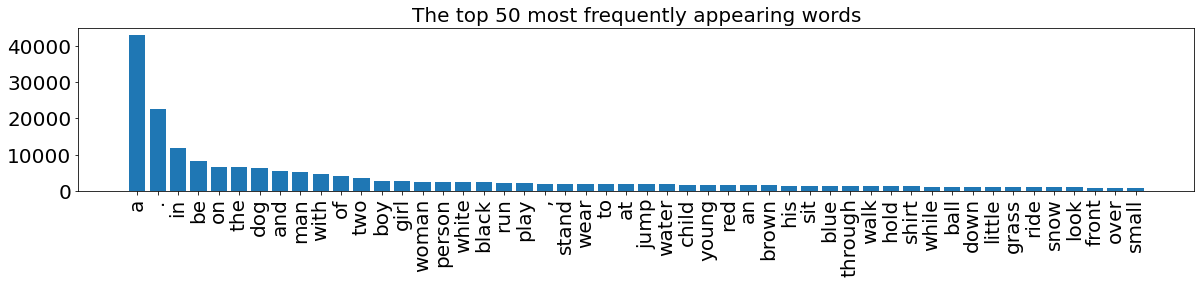

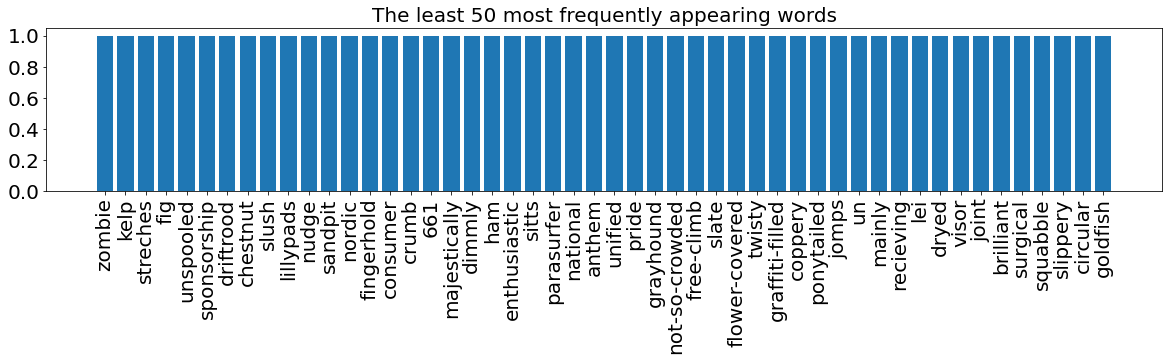

In [92]:
topn = 50
def plthist(dfsub, title="The top 50 most frequently appearing words"):
  plt.figure(figsize=(20,3))
  plt.bar(dfsub.index,dfsub["count"])
  plt.yticks(fontsize=20)
  plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
  plt.title(title,fontsize=20)
  plt.show()
plthist(dfword.iloc[:topn,:],title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],title="The least 50 most frequently appearing words")

In [93]:
from copy import copy
def add_start_end_seq_token(captions):
  caps = []
  for txt in captions:
    txt = 'startseq ' + txt + ' endseq'
    caps.append(txt)
  return(caps)

captions_dict0 = copy(captions_dict)
captions_dict0["caption"] = add_start_end_seq_token(captions_dict["caption"])
captions_dict0.head(5)

#del captions_dict


filename index  \
0  3033668641_5905f73990.jpg     0   
1  2608289957_044849f73e.jpg     0   
2  2723477522_d89f5ac62b.jpg     4   
3  3453019315_cfd5c10dae.jpg     2   
4  3524975665_7bec41578b.jpg     1   

                                             caption  
0  startseq  man in white helmet cling to sheer r...  
1     startseq  baby sit on tire and hold toy endseq  
2         startseq  two dog play in the grass endseq  
3    startseq  man do bike trick on dirt path endseq  
4  startseq  woman in yellow jacket and brown hat...

##Model Building (4 mark)
1.Use Pretrained Mobilenet model trained on ImageNet dataset (available publicly on google) for image feature extraction.

2.Create 3 layered GRU layer model and other relevant layers for image caption generation.

3.Add L2 regularization to all the GRU layers. 

4.Add one layer of dropout at the appropriate position and give reasons. 

5.Choose the appropriate activation function for all the layers. 

6.Print the model summary. 
 

In [94]:
from tensorflow.keras.applications import MobileNet 
from tensorflow.keras.models import Model
mobilenet_model = MobileNet(include_top=True, weights = 'imagenet') 
last = mobilenet_model.layers[-2].output
modele = Model(inputs = mobilenet_model.input,outputs = last) 
modele.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [95]:
dimages, keepindex = [],[] 
nd=(captions_dict0["index"].values) 
b = [(int(i)==0) for i in nd]
#for i in nd:
# print(int(i)==0)
#captions_dict0 = captions_dict0.loc[b,: ]
captions_dict0 = captions_dict0.loc[captions_dict0["index"].values == "0",: ]
for i, fnm in enumerate(captions_dict0.filename): 
  if fnm in captions_dict0.filename.keys(): 
    dimages.append(captions_dict0.filename[fnm]) 
  keepindex.append(i)
 
fnames = captions_dict0["filename"].iloc[keepindex].values 
dcaptions = captions_dict0["caption"].iloc[keepindex].values 
dimages = np.array(dimages)
print(dcaptions)

['startseq  man in white helmet cling to sheer rock face endseq'
 'startseq  baby sit on tire and hold toy endseq'
 'startseq  kayak on river be pass by wire bridge that join both bank endseq'
 ... 'startseq  boston baseball player at bat endseq'
 'startseq  man climb mountain endseq'
 'startseq  dog jump into swim pool endseq']


In [96]:
from keras.preprocessing.text import Tokenizer 
## the maximum number of words in dictionary 
count_words=22000 #nb_words = 31782
tokenizer = Tokenizer(num_words=8000) 
tokenizer.fit_on_texts(dcaptions) 
vocab_size = len(tokenizer.word_index) + 1 
print("vocabulary size : {}".format(vocab_size)) 
dtexts = tokenizer.texts_to_sequences(dcaptions) 
print(dtexts[:5])


vocabulary size : 2764
[[1, 10, 3, 15, 166, 1091, 19, 684, 69, 113, 2], [1, 108, 38, 8, 306, 6, 34, 101, 2], [1, 397, 8, 247, 4, 356, 51, 685, 275, 140, 1476, 339, 632, 2], [1, 910, 1477, 911, 22, 60, 398, 2], [1, 10, 38, 23, 199, 3, 42, 9, 912, 31, 686, 2]]


In [97]:
prop_test, prop_val = 0.2, 0.2

N = len(dtexts)

Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
  return(dtexts[:Ntest],dtexts[Ntest:Ntest+Nval],dtexts[Ntest+Nval:])

dt_test, dt_val, dt_train = split_test_val_train(dtexts,Ntest,Nval)
di_test, di_val, di_train = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train = split_test_val_train(fnames,Ntest,Nval)

In [98]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen) 


28


In [109]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

maxlen = np.max([len(text) for text in dtexts])

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))
    
    try:
      assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    except AssertionError:
      _, _, tb = sys.exc_info()
      traceback.print_tb(tb) # Fixed format
      tb_info = traceback.extract_tb(tb)
      filename, line, func, text = tb_info[-1]   
      exit(1)    

    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to 

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)

Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 2991
 (0,) (0,) (0,)
# captions/images = 997
 (0,) (0,) (0,)


  File "<ipython-input-109-7965030d5696>", line 11, in preprocessing
    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
  File "<ipython-input-109-7965030d5696>", line 11, in preprocessing
    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar


In [120]:
from keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model 
print(vocab_size)
## image feature
dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[0],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.GRU(256,name="CaptionFeature_1",kernel_regularizer=regularizers.l2(0.0001))(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
#decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

2764


NameError: ignored

In [127]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU
print(vocab_size)
import tensorflow as tf
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[0],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature",return_sequences=True)(ftxt)
#,return_sequences=True
#,activation='relu'
se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256,name="CaptionFeature2")(se2)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = Model(inputs=[input_image, input_txt],outputs=output)
#model = tf.keras.Model(input_image, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

2764
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 28)]         0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 28, 64)       176896      ['input_31[0][0]']               
                                                                                                  
 CaptionFeature (LSTM)          (None, 28, 256)      328704      ['embedding_13[0][0]']           
                                                                                                  
 dropout_5 (Dropout)            (None, 28, 256)      0           ['CaptionFeature[0][0]']         
                                                                                       

Task-4 Model Compilation

a. Compile the model with the appropriate loss function.

b. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

##Choice of learning rate:

One of the key hyperparameters to set in order to train a neural network is the learning rate for
gradient descent. this parameter scales the magnitude of our weight updates in order to minimize
the network's loss function.

If learning rate is set too low, training will progress very slowly as you are making very tiny updates
to the weights in neural network. However, if learning rate is set too high, it can cause undesirable
divergent behavior in loss function. so choosing the learning rate 0.001 for Adam optimizer will
gives better weight updates to the network




In [128]:
#regularizer
Loss_fn='categorical_crossentropy'
adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss=Loss_fn, optimizer=adm)
print(model.summary())


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 28)]         0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 28, 64)       176896      ['input_31[0][0]']               
                                                                                                  
 CaptionFeature (LSTM)          (None, 28, 256)      328704      ['embedding_13[0][0]']           
                                                                                                  
 dropout_5 (Dropout)            (None, 28, 256)      0           ['CaptionFeature[0][0]']         
                                                                                            

In [ ]:
start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train,epochs=7, verbose=2, batch_size=64,validation_data=([Ximage_val, Xtext_val], ytext_val))
 #callbacks = [cp_callback]) 
end =time.time()
print("TIME TOOK {:3.2f}MIN".format((end -start )/60))

#**Task-5 Model Training**

a. Train the model for an appropriate number of epochs. Print the train and validation loss for
each epoch. Use the appropriate batch size.

b. Plot the loss and accuracy history graphs for both train and validation set. Print the total
time taken for training.

In [151]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
dir_Flickr_jpg ='/content/drive/MyDrive/DL_Assignment_2/Image_captioning_Dataset/Flicker8k_Dataset/' 
jpgs =os.listdir(Images_directory_extracted)
images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
with progressbar.ProgressBar(max_value=len(jpgs)) as bar:
  for i,name in enumerate(jpgs):
    if i > 100:
      break
 # load an image from file
filename = Images_directory_extracted + '/' + name
image = load_img(filename, target_size=target_size)
# convert the image pixels to a numpy array 
image= img_to_array(image)
nimage =preprocess_input(image)
y_pred = mobilenet_model.predict(nimage.reshape( (1,) +
nimage.shape[:3]))
images[name] = y_pred.flatten()
bar.update(i)


100% (8091 of 8091) |####################| Elapsed Time: 0:00:00 ETA:  00:00:00
  1% (101 of 8091) |                     | Elapsed Time: 0:00:01 ETA:   0:01:51

# **Task-6 Model Evaluation**

Take a random image from google and generate caption for that image

In [160]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[8:13],di_test[8:13]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

<Figure size 720x1440 with 0 Axes>

Predicting on random google image

In [158]:
from google.colab import files as FILE
import os
import requests
DownURL = 'https://media.istockphoto.com/photos/boy-having-fun-with-finger-paint'
img_data = requests.get(DownURL).content
with open('image_name.jpeg', 'wb') as handler:
 handler.write(img_data)
 index_word = dict([index,word])
 for word, index in tokenizer.word_index.items()
 def predict_caption(image):
   '''
   image.shape = (1,4462)

   '''

   in_text = 'startseq'

   for iword in range(maxlen):
     sequence = tokenizer.texts_to_sequences([in_text])[0]
     sequence = pad_sequences([sequence],maxlen)
     yhat = model.predict([image,sequnce],verbose=0)
     yhat = np.argmax(yhat)
     newword = index_word[yhat]
     in_text += " " + newword
     if newword == "endseq":
       break
  return(in_text)


npic =1
npix =224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(5,5))
filename = '/content/random_google_image.jpg'
image_load = load_image(filename, target_size = target_size)
ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
ax.imshow(image_load)


caption=predict_caption(image_feature.reshape(1,len(image_feature)))
ax=fig.add_subplot(npic,2,count+1)
plt.axis('off')
ax.plot()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.text(0,0.5,caption,fontsize=20)

plt.show


SyntaxError: ignored